## Building the whole pipeline in bits !! ##

In [27]:
import numpy as np

In [28]:
# pip install nnfs

### Layer Construction ###

In [29]:
class Dense:
    def __init__(self,inputs,neurons):
        self.weights = 0.01* np.random.randn(inputs,neurons)
        self.bias = np.zeros((1,neurons))

    def forward_prop(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights)+ self.bias

    def backward_prop(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs = np.dot(dvalues,self.weights.T)

### Activation Function ###

In [30]:
class activateReLu:
    def forward_pass(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
    def backward_pass(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [31]:
class activateSoftmax:
    def forward_pass(self,inputs):
        expVals = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
        probs = expVals / np.sum(expVals,axis=1,keepdims=True)
        self.output = probs

### Loss Function ###

In [32]:
class Loss:
    def lossCal(self,output,y):
        sample_losses = self.forward_pass(output,y)
        data_loss = np.mean(sample_losses)

        return data_loss

In [33]:
class CategoricalCrossEntropyFunc(Loss) :
    def forward_pass(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clip = np.clip(y_pred,1e-7,1-1e-7)

        if len(y_true.shape) ==1:
            correct_confidence = y_pred_clip[range(samples),y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_true*y_pred_clip,axis=1)

        neg_likelihoods = -np.log(correct_confidence)
        return neg_likelihoods


    def backward_prop(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true/dvalues
        self.dinputs = self.dinputs/samples

In [34]:
class Softmax_Categorical_Loss():
    def __init__(self):
        self.activation = activateSoftmax()
        self.loss = CategoricalCrossEntropyFunc()

    def forward_prop(self, inputs, y_true):
        self.activation.forward_pass(inputs)
        self.output = self.activation.output

        return self.loss.lossCal(self.output,y_true)

    def backward_prop(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

### Final Testing on Data !!! ###

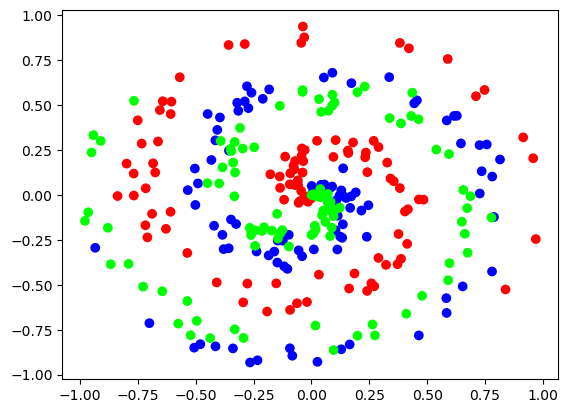

In [35]:
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
nnfs.init()

X,y = spiral_data(samples=100, classes=3)
plt.scatter(X[:,0], X[:,1], c=y, cmap='brg')
plt.show()

In [36]:
"""X,y = spiral_data(samples=100, classes=3)
layer1 = Dense(2,3)
activation_layer_1 = activateReLu()

layer2 = Dense(3,3)
loss_activation = Softmax_Categorical_Loss()

layer1.forward_prop(X)
activation_layer_1.forward_pass(layer1.output)

layer2.forward_prop(activation_layer_1.output)

loss = loss_activation.forward_prop(layer2.output,y)

print("### Results before forward propagation ###")
print(loss_activation.output[:5])

print("Loss : ", loss)

preds = np.argmax(loss_activation.output, axis=1)
# print(preds)
if len(y.shape) == 2:
    y = np.argmax(y,axis=1)
# print(y)

acc = np.mean(preds == y)
print("Accuracy : ", acc)

loss_back = loss_activation.backward_prop(loss_activation.output,y)
layer2.backward_prop(loss_activation.dinputs)
activation_layer_1.backward_pass(layer2.dinputs)
layer1.backward_prop(activation_layer_1.dinputs)
print("### Results before backward propagation ###")
# Print gradients
print(layer1.dweights)
print(layer1.dbiases)
print(layer2.dweights)
print(layer2.dbiases)
"""

'X,y = spiral_data(samples=100, classes=3)\nlayer1 = Dense(2,3)\nactivation_layer_1 = activateReLu()\n\nlayer2 = Dense(3,3)\nloss_activation = Softmax_Categorical_Loss()\n\nlayer1.forward_prop(X)\nactivation_layer_1.forward_pass(layer1.output)\n\nlayer2.forward_prop(activation_layer_1.output)\n\nloss = loss_activation.forward_prop(layer2.output,y)\n\nprint("### Results before forward propagation ###")\nprint(loss_activation.output[:5])\n\nprint("Loss : ", loss)\n\npreds = np.argmax(loss_activation.output, axis=1)\n# print(preds)\nif len(y.shape) == 2:\n    y = np.argmax(y,axis=1)\n# print(y)\n\nacc = np.mean(preds == y)\nprint("Accuracy : ", acc)\n\nloss_back = loss_activation.backward_prop(loss_activation.output,y)\nlayer2.backward_prop(loss_activation.dinputs)\nactivation_layer_1.backward_pass(layer2.dinputs)\nlayer1.backward_prop(activation_layer_1.dinputs)\nprint("### Results before backward propagation ###")\n# Print gradients\nprint(layer1.dweights)\nprint(layer1.dbiases)\nprint(

In [37]:
# print(preds)

### Building the Optimizer ###

In [38]:
class Optimizer_GD:
    def __init__(self,learning_rate=0.09):
        self.learning_rate = learning_rate

    def update_params(self,layer):
        layer.weights += -self.learning_rate*layer.dweights
        layer.bias += -self.learning_rate*layer.dbiases

epoch: 0, acc: 0.343, loss: 1.099
epoch: 100, acc: 0.433, loss: 1.098
epoch: 200, acc: 0.420, loss: 1.098
epoch: 300, acc: 0.420, loss: 1.098
epoch: 400, acc: 0.417, loss: 1.097
epoch: 500, acc: 0.410, loss: 1.096
epoch: 600, acc: 0.407, loss: 1.095
epoch: 700, acc: 0.407, loss: 1.092
epoch: 800, acc: 0.417, loss: 1.088
epoch: 900, acc: 0.420, loss: 1.085
epoch: 1000, acc: 0.420, loss: 1.081
epoch: 1100, acc: 0.423, loss: 1.079
epoch: 1200, acc: 0.440, loss: 1.077
epoch: 1300, acc: 0.440, loss: 1.076
epoch: 1400, acc: 0.440, loss: 1.076
epoch: 1500, acc: 0.443, loss: 1.075
epoch: 1600, acc: 0.453, loss: 1.075
epoch: 1700, acc: 0.463, loss: 1.074
epoch: 1800, acc: 0.470, loss: 1.074
epoch: 1900, acc: 0.467, loss: 1.073
epoch: 2000, acc: 0.467, loss: 1.073
epoch: 2100, acc: 0.460, loss: 1.072
epoch: 2200, acc: 0.460, loss: 1.072
epoch: 2300, acc: 0.453, loss: 1.072
epoch: 2400, acc: 0.457, loss: 1.071
epoch: 2500, acc: 0.453, loss: 1.071
epoch: 2600, acc: 0.453, loss: 1.071
epoch: 2700, 

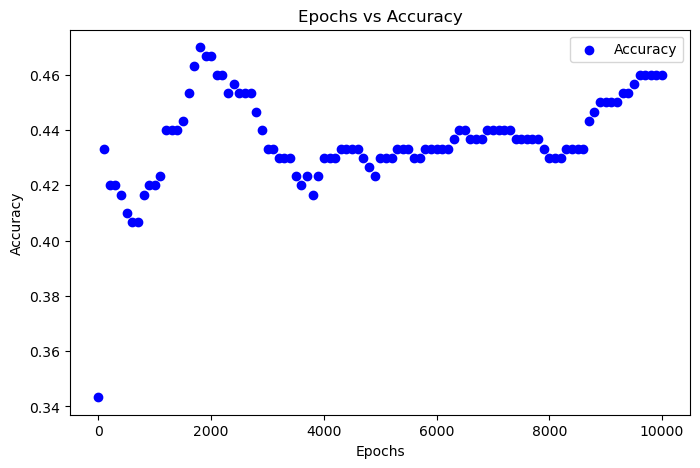

In [39]:
X,y = spiral_data(samples=100, classes=3)
layer1 = Dense(2,64)
activation_layer_1 = activateReLu()

layer2 = Dense(64,3)
loss_activation = Softmax_Categorical_Loss()
optim = Optimizer_GD()

epochs = []
accuracies = []
for epoch in range (10001):
    layer1.forward_prop(X)
    activation_layer_1.forward_pass(layer1.output)
    
    layer2.forward_prop(activation_layer_1.output)
    
    loss = loss_activation.forward_prop(layer2.output,y)
    
    # print("### Results before forward propagation ###")
    # print(loss_activation.output[:5])
    
    
    
    preds = np.argmax(loss_activation.output, axis=1)
    # print(preds)
    if len(y.shape) == 2:
        y = np.argmax(y,axis=1)
    # print(y)
    
    acc = np.mean(preds == y)
    # print("Accuracy : ", acc)
    if not epoch %100:
        print(f'epoch: {epoch}, ' +
              f'acc: {acc:.3f}, ' +
              f'loss: {loss:.3f}')
        epochs.append(epoch)
        accuracies.append(acc)
    loss_activation.backward_prop(loss_activation.output,y)
    layer2.backward_prop(loss_activation.dinputs)
    activation_layer_1.backward_pass(layer2.dinputs)
    layer1.backward_prop(activation_layer_1.dinputs)

    optim.update_params(layer1)
    optim.update_params(layer2)
# print("### Results before backward propagation ###")
# Print gradients
# print(layer1.dweights)
# print(layer1.dbiases)
# print(layer2.dweights)
# print(layer2.dbiases)

plt.figure(figsize=(8, 5))
plt.scatter(epochs, accuracies, color='blue', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()

### Learning Rate Decay ###

In [42]:
class Optimizer_GD:
    def __init__(self,learning_rate=0.0, decay= 0.0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.curr_learning_rate = learning_rate
        self.iterations = 0 

    def pre_update_params(self):
        if self.decay:
            self.curr_learning_rate = self.learning_rate * (1.0/(1+self.decay*self.iterations))
    def update_params(self,layer):
        layer.weights += -self.curr_learning_rate*layer.dweights
        layer.bias += -self.curr_learning_rate*layer.dbiases

    def post_update_params(self):
        self.iterations +=1

epoch: 0, acc: 0.333, loss: 1.099,lr: 2.0
epoch: 100, acc: 0.397, loss: 1.074,lr: 1.8198362147406735
epoch: 200, acc: 0.433, loss: 1.072,lr: 1.6680567139282734
epoch: 300, acc: 0.427, loss: 1.070,lr: 1.539645881447267
epoch: 400, acc: 0.417, loss: 1.065,lr: 1.4295925661186561
epoch: 500, acc: 0.400, loss: 1.065,lr: 1.33422281521014
epoch: 600, acc: 0.403, loss: 1.057,lr: 1.2507817385866167
epoch: 700, acc: 0.387, loss: 1.049,lr: 1.1771630370806356
epoch: 800, acc: 0.400, loss: 1.031,lr: 1.1117287381878822
epoch: 900, acc: 0.450, loss: 1.015,lr: 1.05318588730911
epoch: 1000, acc: 0.453, loss: 1.002,lr: 1.0005002501250624
epoch: 1100, acc: 0.480, loss: 0.987,lr: 0.9528346831824678
epoch: 1200, acc: 0.447, loss: 0.968,lr: 0.9095043201455207
epoch: 1300, acc: 0.447, loss: 0.995,lr: 0.8699434536755111
epoch: 1400, acc: 0.473, loss: 0.942,lr: 0.8336807002917882
epoch: 1500, acc: 0.477, loss: 0.960,lr: 0.8003201280512204
epoch: 1600, acc: 0.523, loss: 0.930,lr: 0.7695267410542516
epoch: 1700,

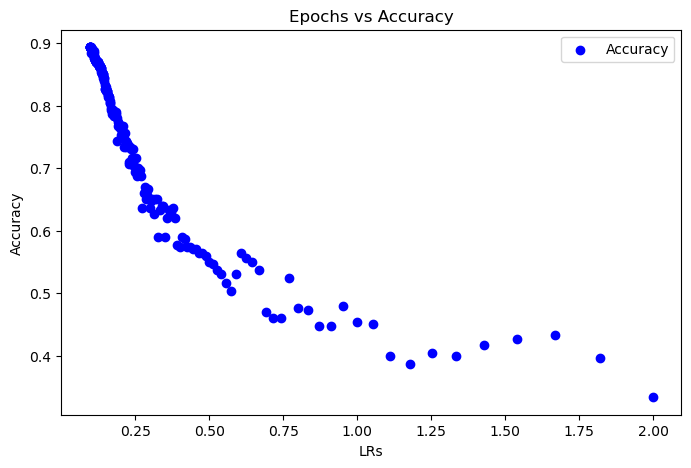

In [46]:
X,y = spiral_data(samples=100, classes=3)
layer1 = Dense(2,64)
activation_layer_1 = activateReLu()

layer2 = Dense(64,3)
loss_activation = Softmax_Categorical_Loss()
optim = Optimizer_GD(learning_rate=2.0,decay=1e-3)

lrs = []
accuracies = []
for epoch in range (20001):
    layer1.forward_prop(X)
    activation_layer_1.forward_pass(layer1.output)
    
    layer2.forward_prop(activation_layer_1.output)
    
    loss = loss_activation.forward_prop(layer2.output,y)
    
    # print("### Results before forward propagation ###")
    # print(loss_activation.output[:5])
    
    
    
    preds = np.argmax(loss_activation.output, axis=1)
    # print(preds)
    if len(y.shape) == 2:
        y = np.argmax(y,axis=1)
    # print(y)
    
    acc = np.mean(preds == y)
    # print("Accuracy : ", acc)
    if not epoch %100:
        print(f'epoch: {epoch}, ' +
              f'acc: {acc:.3f}, ' +
              f'loss: {loss:.3f},' +
             f'lr: {optim.curr_learning_rate}')
        lrs.append(optim.curr_learning_rate)
        accuracies.append(acc)
    loss_activation.backward_prop(loss_activation.output,y)
    layer2.backward_prop(loss_activation.dinputs)
    activation_layer_1.backward_pass(layer2.dinputs)
    layer1.backward_prop(activation_layer_1.dinputs)

    optim.pre_update_params()
    optim.update_params(layer1)
    optim.update_params(layer2)
    optim.post_update_params()
# print("### Results before backward propagation ###")
# Print gradients
# print(layer1.dweights)
# print(layer1.dbiases)
# print(layer2.dweights)
# print(layer2.dbiases)

plt.figure(figsize=(8, 5))
plt.scatter(lrs, accuracies, color='blue', label='Accuracy')
plt.xlabel('LRs')
plt.ylabel('Accuracy')
plt.title('LRs vs Accuracy')
plt.legend()
plt.show()

### Momentum ###

In [ ]:
class Optimizer_GD:
    def __init__(self,learning_rate=0.0, decay= 0.0, momen=0.0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.curr_learning_rate = learning_rate
        self.iterations = 0 
        self.momentum = momen

    def pre_update_params(self):
        if self.decay:
            self.curr_learning_rate = self.learning_rate * (1.0/(1+self.decay*self.iterations))
    def update_params(self,layer):
        if self.momentum:
            if not hasattr(layer,'weights_momentums'):
                layer.weights_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.bias)

        
        layer.weights += -self.curr_learning_rate*layer.dweights
        layer.bias += -self.curr_learning_rate*layer.dbiases

    def post_update_params(self):
        self.iterations +=1